In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from time import time
from torchvision import datasets, transforms

## generate data

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('../../data', download=True, train=True, transform=transform)
valset = datasets.MNIST('../../data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
print(images[0])

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

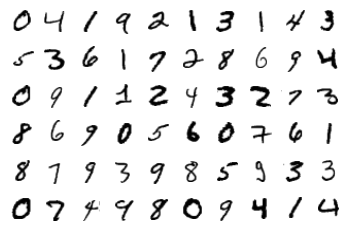

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Generate network

In [26]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size1 = 1000

hidden_size2 = 100

hidden_size3 = 100

num_classes = 10
batch_size = batchsize


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        #self.fc1.weight.detach().normal_(0.0, 0.1)
        #self.fc1.bias.detach().normal_(0.0, 0.1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        #self.fc2.weight.detach().uniform_(-1,1)
        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)
        
        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        
        
        out = self.fc3(out)
        out = self.relu2(out)
        out = self.fc4(out)
        
        out = self.lsm(out)
        return out

## Learning Regime Modification

In [27]:
def LRM(model,i,beta=1.0):
    with torch.no_grad():
        model.fc1.weight[i,:]=model.fc1.weight[i,:]/beta
        model.fc1.bias[i]=model.fc1.bias[i]/beta
        model.fc2.weight[:,i]=model.fc2.weight[:,i]*beta

def LRD(model,i):
    with torch.no_grad():
        a=model.fc1.weight[i][0].detach().clone().numpy() 
        b=model.fc1.bias[i].detach().clone().numpy() 
        c=model.fc2.weight[0][i].detach().clone().numpy()
        xx=torch.tensor(-b/a).reshape(-1, 1).to(device).float()
        fout=model(xx).numpy() 
    return [a,b,c],-b/a,c**2-a**2-b**2,fout

def adjust(model,images,threshold_u=100.0,threshold_l=0.1,scale=1.0):
    L=len(images)
    d_=torch.zeros(hidden_size1)
    with torch.no_grad():
        for i in range(hidden_size1):
            d=0
            for k in range(L):
                image=images[k]
                l=-model.fc1.weight[i]/model.fc1.bias[i]
                x_k=1/image
                d_k=torch.abs(torch.sum(l*x_k)-1.0)/torch.norm(x_k)
                d=d+d_k

            d_[i]=d/L
        d_=d_*scale
        d_=d_**2
        d_=torch.min(d_,torch.tensor(threshold_u*1.0))
        d_=torch.max(d_,torch.tensor(threshold_l*1.0))
        
        #print(d_)
        for i in range(hidden_size1):
            LRM(model,i,d_[i])
    



## Plot function

In [28]:
def plot_training(model,node_num=1000):
    plt.plot(train_data,train_label,'-o',label=r'$x_j,y_j$')

    
    x= np.linspace(Nmin, Nmax, num=node_num)
    y= np.zeros(node_num)
    with torch.no_grad():
        for i in range(node_num):
            xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
            y[i]=model(xx).numpy()
    plt.plot(x,y,'-',label=r'$x,f(x)$')
    
    

In [29]:
print(len(train_loader))

938


## Training

In [30]:
learning_rate = 0.001
torch.manual_seed(0)
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
ad=True
if ad:
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1)
    #adjust(model,images,threshold_u=1,threshold_l=0.01,scale=0.8)
    adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.8)
    #adjust(model,images,threshold_u=10,threshold_l=1,scale=0.8)
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
num_epochs=700
dev=100
losslist=[]


totalloss=[]




for epoch in range(num_epochs):
    loss_epoch=0
    for i, (images, labels) in enumerate(train_loader):  
        

        images = images.view(images.shape[0], -1)
        
        #print(images,labels)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        totalloss.append(loss.item())

        loss_epoch=loss_epoch+loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch=loss_epoch/len(train_loader) 
    losslist.append(loss_epoch)
    if loss_epoch<0.02:
        break
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))


Epoch [1/700], Loss: 0.5997


KeyboardInterrupt: 

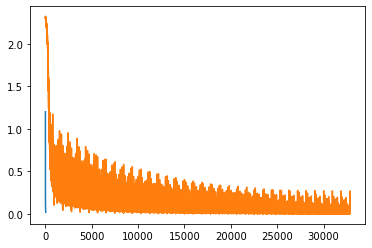

In [19]:
plt.plot(losslist)
plt.plot(totalloss)

In [ ]:
Epoch [1/700], Loss: 1.2010
Epoch [2/700], Loss: 0.3898
Epoch [3/700], Loss: 0.3145
Epoch [4/700], Loss: 0.2723
Epoch [5/700], Loss: 0.2394
Epoch [6/700], Loss: 0.2112
Epoch [7/700], Loss: 0.1872
Epoch [8/700], Loss: 0.1672
Epoch [9/700], Loss: 0.1504
Epoch [10/700], Loss: 0.1361
Epoch [11/700], Loss: 0.1237
Epoch [12/700], Loss: 0.1128
Epoch [13/700], Loss: 0.1033
Epoch [14/700], Loss: 0.0948
Epoch [15/700], Loss: 0.0873
Epoch [16/700], Loss: 0.0805
Epoch [17/700], Loss: 0.0744
Epoch [18/700], Loss: 0.0688
Epoch [19/700], Loss: 0.0637
Epoch [20/700], Loss: 0.0590
Epoch [21/700], Loss: 0.0548
Epoch [22/700], Loss: 0.0508
Epoch [23/700], Loss: 0.0471
Epoch [24/700], Loss: 0.0436
Epoch [25/700], Loss: 0.0405
Epoch [26/700], Loss: 0.0375
Epoch [27/700], Loss: 0.0347
Epoch [28/700], Loss: 0.0322
Epoch [29/700], Loss: 0.0298
Epoch [30/700], Loss: 0.0276
Epoch [31/700], Loss: 0.0256
Epoch [32/700], Loss: 0.0237
Epoch [33/700], Loss: 0.0219
Epoch [34/700], Loss: 0.0203


In [73]:
with open('bu20_bl20_s20.npy', 'wb') as f:
    np.save(f, [losslisto,losslisto20,losslisto02,losslisto2002])

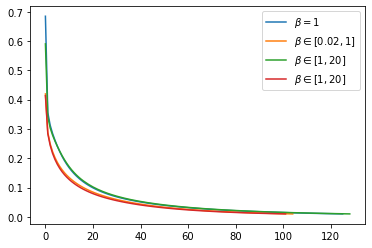

In [74]:
plt.plot(losslisto,label=r'$\beta=1$')
plt.plot(losslisto02,label=r'$\beta \in [0.02,1]$')
plt.plot(losslisto20,label=r'$\beta \in [1,20]$')
plt.plot(losslisto2002,label=r'$\beta \in [0.02,20]$')
plt.legend()

plt.savefig('scale0_2zoom.pdf')

In [64]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1)

In [26]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1)

torch.manual_seed(0)
model = NeuralNet(input_size, hidden_size1, num_classes).to(device)

L=len(images)
d_=torch.zeros(hidden_size1)
with torch.no_grad():
    for i in range(hidden_size1):
        d=0
        for k in range(L):
            image=images[k]
            l=-model.fc1.weight[i]/model.fc1.bias[i]
            x_k=1/image
            d_k=torch.abs(torch.sum(l*x_k)-1.0)/torch.norm(x_k)
            d=d+d_k

        d_[i]=d/L
d_=torch.min(d_,torch.tensor(100.))

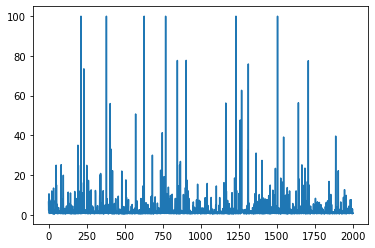

In [27]:
plt.plot(d_)

In [41]:
d_=torch.min(d_,torch.tensor(1000.0))

In [77]:
print(model.fc1.bias[i])

tensor(0.0016, grad_fn=<SelectBackward>)


In [73]:
print(model.fc1.weight[i]/model.fc1.bias[i])

tensor([  0.3938,  12.7157, -18.0815, -16.1082,  -8.1617,   6.6382,   0.1146,
         18.5251,  -1.4470,   6.5579,  -6.2827,  -3.8895, -21.0913, -14.4674,
         -8.7751,   1.4026,   9.5192,  14.1560, -14.7944,  -9.3013,   8.7916,
         19.3746,  -4.0987,  17.5153,  -3.0880,   2.9605,  21.0756, -20.4516,
        -13.6979,  -5.1716,  -8.2669,  20.1361, -14.1202,  -9.8650, -15.2786,
        -20.6982, -12.7079,  20.0023,  10.6174,  11.4215,   1.5184, -11.1892,
          4.3424, -20.8845, -16.4666, -11.4239,  14.7967,  13.7944,  -9.5144,
         -0.3019,  15.0033,  23.0782,   9.5542,   3.6237,  15.7523, -12.7751,
          4.7848, -17.0000, -15.1375, -11.1397,  10.8121,   9.6732, -12.8834,
          7.3105,  12.8501,  -2.5133,   0.9127,   5.1497,  13.8470,  21.7234,
        -17.6005,  -8.3968,   8.7120,  18.9126,  20.2735,  20.2715,   4.9290,
        -19.2688,   2.5351, -13.6597, -20.5657,  20.6862,  17.7882, -22.0342,
          4.8035,  -3.2528,  -3.1630,  -9.8091,   9.2784, -13.04

In [83]:
-1.2867e-02/1.5765*1000

-8.16175071360609

In [81]:
model.fc1.bias[i]*1000

tensor(1.5765, grad_fn=<MulBackward0>)

In [84]:
image=images[1]

In [42]:
data=np.load('bu20_bl20_s20.npy',allow_pickle=True)

In [43]:
len(data)

4

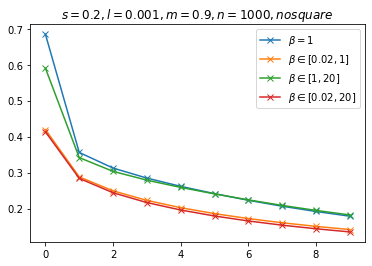

In [47]:
plt.plot(data[0][:10],'x-',label=r'$\beta=1$')
plt.plot(data[2][:10],'x-',label=r'$\beta \in [0.02,1]$')
plt.plot(data[1][:10],'x-',label=r'$\beta \in [1,20]$')
plt.plot(data[3][:10],'x-',label=r'$\beta \in [0.02,20]$')
plt.title(r'$s=0.2,l=0.001,m=0.9,n=1000,nosquare$')
plt.legend()
plt.savefig('scale0_2zoom.pdf')

In [31]:
def test(flag):
    learning_rate = 0.001
    torch.manual_seed(0)
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    
    print(flag)

    if flag>0:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)
        if flag==1:
            adjust(model,images,threshold_u=1,threshold_l=0.01,scale=0.8)
        if flag==2:
            adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.8)
        if flag==3:
            adjust(model,images,threshold_u=10,threshold_l=1,scale=0.8)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]

    


    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):  


            images = images.view(images.shape[0], -1)

            #print(images,labels)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)


            totalloss.append(loss.item())

            loss_epoch=loss_epoch+loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        if loss_epoch<0.02:
            break
        
        #print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        
    return losslist,totalloss


In [32]:
lt=[]
tt=[]
for ti in [0,1,2,3]:
    losslist,totalloss=test(ti)
    lt.append(losslist)
    tt.append(totalloss)


0
1
2
3


In [34]:
with open('deepbu10_bl01_s08.npy', 'wb') as f:
    np.save(f, [lt,tt])

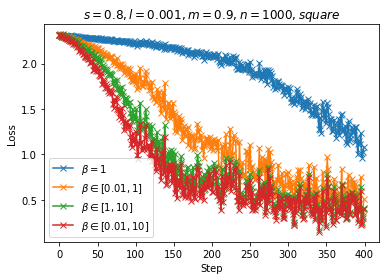

In [37]:
plt.plot(tt[0][:400],'x-',label=r'$\beta=1$')
plt.plot(tt[1][:400],'x-',label=r'$\beta \in [0.01,1]$')
plt.plot(tt[3][:400],'x-',label=r'$\beta \in [1,10]$')
plt.plot(tt[2][:400],'x-',label=r'$\beta \in [0.01,10]$')
plt.title(r'$s=0.8,l=0.001,m=0.9,n=1000,square$')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('deepscale0_8diszoom.pdf')

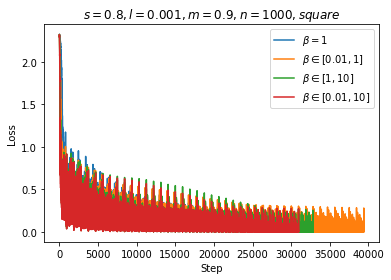

In [38]:
plt.plot(tt[0],'-',label=r'$\beta=1$')
plt.plot(tt[1],'-',label=r'$\beta \in [0.01,1]$')
plt.plot(tt[3],'-',label=r'$\beta \in [1,10]$')
plt.plot(tt[2],'-',label=r'$\beta \in [0.01,10]$')
plt.title(r'$s=0.8,l=0.001,m=0.9,n=1000,square$')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend()
plt.savefig('deepscale0_8dis.pdf')

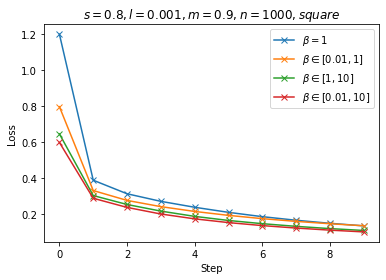

In [41]:
plt.plot(lt[0][:10],'x-',label=r'$\beta=1$')
plt.plot(lt[1][:10],'x-',label=r'$\beta \in [0.01,1]$')
plt.plot(lt[3][:10],'x-',label=r'$\beta \in [1,10]$')
plt.plot(lt[2][:10],'x-',label=r'$\beta \in [0.01,10]$')
plt.title(r'$s=0.8,l=0.001,m=0.9,n=1000,square$')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('deepscale0_8zoom.pdf')

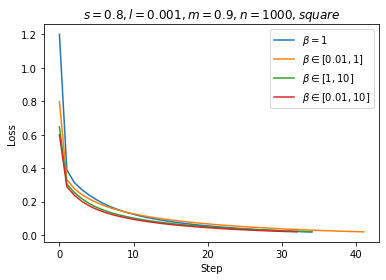

In [40]:
plt.plot(lt[0],'-',label=r'$\beta=1$')
plt.plot(lt[1],'-',label=r'$\beta \in [0.01,1]$')
plt.plot(lt[3],'-',label=r'$\beta \in [1,10]$')
plt.plot(lt[2],'-',label=r'$\beta \in [0.01,10]$')
plt.title(r'$s=0.8,l=0.001,m=0.9,n=1000,square$')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend()
plt.savefig('deepscale0_8.pdf')